<a href="https://colab.research.google.com/github/soesantanu/soesantanu.github.io/blob/main/Graph_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
import builtins, time
import numpy as np
import numpy.linalg as LA
import builtins, time
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
# =========================
# 1) DATA GENERATION
# =========================
def grid_graph_incidence(nx: int, ny: int):
    """
    Build incidence/gradient matrix D for a 2D grid (nx x ny) with 4-neighborhood.
    Each row of D has +1 and -1 for an edge.
    Returns: D (sparse), n_nodes
    """
    def node(i, j): return i * ny + j
    edges = []
    for i in range(nx):
        for j in range(ny):
            if i < nx - 1:  # vertical edge
                edges.append((node(i, j), node(i + 1, j)))
            if j < ny - 1:  # horizontal edge
                edges.append((node(i, j), node(i, j + 1)))

    n = nx * ny
    m_edges = len(edges)
    data = np.concatenate([np.ones(m_edges), -np.ones(m_edges)])
    rows = np.concatenate([np.arange(m_edges), np.arange(m_edges)])
    cols = np.concatenate([np.array([e[0] for e in edges]),
                           np.array([e[1] for e in edges])])
    D = sp.csr_matrix((data, (rows, cols)), shape=(m_edges, n))
    return D, n

def gen_graphnet_synthetic(m=1000, nx=30, ny=30, noise=0.01, seed=0,
                           lam1=1e-2, lam2=1e-1):
    """
    Synthetic regression data for GraphNet-like model.
    - Features x live on a 2D grid graph.
    - A is random Gaussian, b = A x_true + noise.
    """
    rng = np.random.default_rng(seed)
    D, n = grid_graph_incidence(nx, ny)

    # Create a "smooth + sparse" ground truth signal on the grid.
    # Start from random, smooth via a Laplacian-like filter, then hard-threshold for sparsity.
    x0 = rng.normal(size=n)
    # Smooth: solve (I + alpha * L) x = x0  with L = D^T D
    alpha = 2.0
    L = D.T @ D  # sparse
    # (I + alpha L) x = x0  then use Conjugate gradient method
    A_mat = sp.eye(n) + alpha * L
    x_smooth, _ = spla.cg(A_mat, x0, maxiter=2000)
    # Impose sparsity
    k_keep = max(1, n // 20)  # keep ~~5% nonzeros
    thresh = np.partition(np.abs(x_smooth), -k_keep)[-k_keep]
    x_true = np.where(np.abs(x_smooth) >= thresh, x_smooth, 0.0)

    # Measurement matrix and noisy response
    A = rng.normal(size=(m, n)) / np.sqrt(m)
    b = A @ x_true + noise * rng.normal(size=m)

    data = {
        "A": A, "b": b, "D": D,
        "x_true": x_true,
        "lam1": lam1, "lam2": lam2,
        "nx": nx, "ny": ny
    }
    return data

# =========================
# 2) PROBLEM DEFINITIONS
# =========================
def h_val_grad(x, A, b):
    """ h(x) = 1/(2m) ||Ax - b||^2, grad h = A^T (Ax-b)/m """
    m = A.shape[0]
    r = A @ x - b
    return 0.5 * np.dot(r, r) / m, (A.T @ r) / m

def f_val(x, lam1):
    return lam1 * np.linalg.norm(x, 1)

def g_val(z, lam2):
    return 0.5 * lam2 * np.dot(z, z)

def F_val(x, A, b, D, lam1, lam2):
    hv, _ = h_val_grad(x, A, b)
    return hv + f_val(x, lam1) + g_val(D @ x, lam2)

def prox_f(u, tau, lam1):
    return np.sign(u) * np.maximum(np.abs(u) - tau*lam1, 0.)

def prox_g_conj(v, lam2, sigma):
    return v / (1.0 + sigma/lam2)


# =========================
# Compute the norm of D
# =========================
def spectral_norm_K(D, n_iter=5000):
    """ Power iteration for ||D||_2 """
    x = np.random.randn(D.shape[1])
    x /= np.linalg.norm(x)
    for _ in range(n_iter):
        x = D.T @ (D @ x)
        x_norm = np.linalg.norm(x)
        if x_norm == 0:
            return 0.0
        x /= x_norm
    return np.sqrt(x_norm)

In [ ]:
if __name__ == "__main__":
    data = gen_graphnet_synthetic(m=300, nx=30, ny=30,
                                  noise=0.001, seed=42,
                                  lam1=6.64e-06, lam2=0.000001)

    A, b, D = data["A"], data["b"], data["D"]
    lam1, lam2 = data["lam1"], data["lam2"]
    norm_D = spectral_norm_K(D, n_iter=5000)
    print(f"norm={norm}")
    print(A.shape, b.shape, D.shape)
    print(f"lam1={lam1}, lam2={lam2}")

norm=2.824550863672505
(300, 900) (300,) (1740, 900)
lam1=6.64e-06, lam2=1e-06


In [ ]:
from scipy.sparse.linalg import eigsh
m, n = A.shape
# compute the largest eigenvalue of A^T A
# which='LM' asks for the Largest Magnitude eigenvalue
vals, _ = eigsh(A.T @ A, k=1, which='LM')
L = vals[0] / m
print(f"Lipschitz constant L = {L:.30e}")

Lipschitz constant L = 2.473923503187034494965601538752e-02


In [ ]:
import numpy as np
# compute largest singular value of A
s_max = np.linalg.norm(A, ord=2)       # spectral norm
L     = (s_max**2) / m
print(f"Lipschitz constant L = {L:.30e}")


Lipschitz constant L = 2.473923503187028596905783217608e-02


In [ ]:
def dh(x):      # gradient of h
    r = A @ x - b
    return (A.T @ r) / A.shape[0]

def F_val(x):
    r = A @ x - b
    h = 0.5*np.dot(r, r)/A.shape[0]
    f = lam1*np.linalg.norm(x,1)
    g = 0.5*lam2*np.dot(D@x, D@x)
    return h+f+g

def J(x):
    return F_val(x)

# ---------------- Metrics we want ----------------
x_true = data["x_true"]
err_hist = []          # relative error ||x_k - x_tru|| / ||x_true||
Fx_hist  = []          # objective values

def pd_adaptive_Golden(J, prox_f, prox_g_conj, K, norm_K,
                       x0, y0, tau, theta, beta, lam1, lam2,
                       tau_max, rho_val, phi, numb_iter=1000):
    begin = time.time()

    x, y, z = x0.copy(), y0.copy(), x0.copy()
    values  = [J(x0)]
    tau_prev, theta_prev = tau, theta
    tt, tau_values, sigma_values = [0.0], [], []

    for i in range(numb_iter):
        z   = x - (1.0/phi) * (x - z)
        x1  = prox_f(z - tau_prev*(K.T @ y) - tau_prev*dh(x), tau_prev, lam1)

        Kx1 = K @ x1
        x_norm   = LA.norm(x - x1)**2
        dhx_norm = LA.norm(dh(x) - dh(x1))**2

        if dhx_norm != 0 and x_norm != 0:
            L_bar_prev = dhx_norm / x_norm
            L_current1 = (phi * theta_prev) / (9.0 * tau_prev)
            L_n        = L_current1 / (L_bar_prev + phi * beta * norm_K**2)
            tau_n      = builtins.min(rho_val * tau_prev, L_n, tau_max)
        else:
            tau_n      = builtins.min(rho_val * tau_prev, tau_max)

        sigma_n = beta * tau_n
        y1      = prox_g_conj(y + sigma_n * Kx1, lam2, sigma_n)

        gap_val = J(x1)
        rel_err = LA.norm(x1 - x_true)/ LA.norm(x_true)
        # store
        values.append(gap_val)
        err_hist.append(rel_err)
        Fx_hist.append(F_val(x1))
        tau_values.append(tau_n)
        sigma_values.append(sigma_n)
        tt.append(time.time() - begin)

        if i % 50 == 0:
            print(f"Iter {i:4d}: F={gap_val:.30e}, rel_err={rel_err:.30e}, "
                  f"tau={tau_n:.3e}, sigma={sigma_n:.3e}")

        theta_n   = phi * (tau_n / tau_prev)
        x, y      = x1, y1
        tau_prev, theta_prev = tau_n, theta_n

        if gap_val <= 1e-16:
            print("Terminated: gap <= 1e-16")
            break
    else:
        print("Adaptive Golden-Ratio PDA did not hit the tolerance.")

    return [values, x, y, tt, sigma_values, tau_values, err_hist, Fx_hist]


In [ ]:
def pd_Golden_Partial_adaptive(J, prox_f, prox_g_conj, K, x0, y0,
                               mu, mu1, lam1, lam2, beta, phi, tau,
                               numb_iter=100, tol=1e-16):
    """
    Golden‐Ratio PDA with partial adaptive step size, recording:
      - values:      primal–dual gap history J(x_k,y_k)
      - err_hist:    relative error ‖x_k – x_true‖/‖x_true‖
      - Fx_hist:     objective F(x_k)
      - tau_values:  primal stepsizes τ_k
      - sigma_values:dual stepsizes σ_k
      - tt:          CPU time per iteration
    """
    begin        = time.time()
    x, y, z      = x0.copy(), y0.copy(), x0.copy()
    values       = [J(x0)]
    err_hist     = []
    Fx_hist      = []
    tt           = [0.0]
    tau_prev     = tau
    tau_values   = []
    sigma_values = []

    for i in range(numb_iter):
        z   = x - (1/phi)*(x - z)
        # primal update
        x1  = prox_f(z - tau_prev*(K.T @ y) - tau_prev*dh(x),
                     tau_prev, lam1)

        # compute norms
        x_norm   = LA.norm(x - x1)
        dhx_norm = LA.norm(dh(x) - dh(x1))
        Kx_norm  = LA.norm(K.dot(x) - K.dot(x1))

        # adaptive τ_k
        if Kx_norm !=0 and dhx_norm !=0:
            tau_n = builtins.min(tau_prev,
                                 (mu/np.sqrt(beta))*(x_norm/Kx_norm),
                                 mu1*(x_norm/dhx_norm))
        elif Kx_norm != 0:
            tau_n = min(tau_prev, (mu/np.sqrt(beta))*(x_norm/Kx_norm))
        elif dhx_norm != 0:
            tau_n = min(tau_prev, mu1*(x_norm/dhx_norm))
        else:
            tau_n = tau_prev
        sigma_n = beta * tau_n

        # dual update
        y1 = prox_g_conj(y + sigma_n*(K.dot(x1)), lam2, sigma_n)

        # Append values
        gap     = J(x1)
        rel_err = LA.norm(x1 - x_true)/LA.norm(x_true)
        obj_val = F_val(x1)

        values.append(gap)
        err_hist.append(rel_err)
        Fx_hist.append(obj_val)
        tau_values.append(tau_n)
        sigma_values.append(sigma_n)
        tt.append(time.time() - begin)
        if i % 50 == 0:
            print(f"Iter {i:4d}: F={gap:.30e}, rel_err={rel_err:.30e}, "
                  f"tau={tau_n:.3e}, sigma={sigma_n:.3e}")

        # convergence check
        if gap <= tol:
            print(f"[pd_partial] Converged at iter {i+1}, time {tt[-1]:.3f}s")
            x, y = x1, y1
            break

        # The next iterates
        x, y, tau_prev = x1, y1, tau_n

    else:
        print(f"[pd_partial] Did not converge in {numb_iter} iters (last gap={values[-1]:.2e})")

    return [values, x, y, tt, sigma_values, tau_values, err_hist, Fx_hist]


In [ ]:
def VI_adaptive_Golden(J, prox_f, prox_g_conj, K, x0, y0, tau, theta, rho, tau_max, phi, numb_iter=100, tol=1e-16):
    """
    Adaptive Golden‐Ratio method for variational inequalities, now recording:
      - values       : history of J(x_k,y_k,min_val)
      - err_hist     : relative error ‖x_k – x_true‖/‖x_true‖
      - Fx_hist      : objective F_val(x_k)
      - tau_values   : primal stepsizes τ_k
      - sigma_values : empty (no dual σ in this VI scheme)
      - tt           : CPU time stamps per iteration
    """
    begin       = time.time()
    x, y        = x0.copy(), y0.copy()
    x1, y1      = x0.copy(), y0.copy()
    z_x, z_y    = x0.copy(), y0.copy()

    values      = [J(x)]
    err_hist    = []
    Fx_hist     = []
    tt          = [0.0]
    tau_prev    = tau
    theta_prev  = theta
    tau_values  = []

    for i in range(numb_iter):
        z0    = np.concatenate((x,   y))
        z1    = np.concatenate((x1, y1))
        Fz_0  = np.concatenate((K.T.dot(y)   + dh(x),
                                 -K.dot(x)))
        Fz_1  = np.concatenate((K.T.dot(y1) + dh(x1),
                                 -K.dot(x1)))
        z_norm  = LA.norm(z0 - z1)
        Fz_norm = LA.norm(Fz_0 - Fz_1)

        if Fz_norm != 0:
            L_n   = (phi * theta_prev/(4*tau_prev))*(z_norm/Fz_norm)**2
            tau_n = builtins.min(rho*tau_prev, L_n, tau_max)
        else:
            tau_n = builtins.min(rho*tau_prev, tau_max)

        # The convex combination
        z_x = x1 - (1/phi)*(x1 - z_x)
        z_y = y1 - (1/phi)*(y1 - z_y)

        # primal / dual updates
        x2 = prox_f(z_x - tau_n*K.T.dot(y1) - tau_n*dh(x1),
                    tau_n, lam1)
        y2 = prox_g_conj(z_y + tau_n*K.dot(x1),
                         lam2, tau_n)

        # record step sizes
        tau_values.append(tau_n)

        # compute metrics
        gap     = J(x2)
        rel_err = LA.norm(x2 - x_true)/LA.norm(x_true)
        obj_val = F_val(x2)

        values.append(gap)
        err_hist.append(rel_err)
        Fx_hist.append(obj_val)
        tt.append(time.time() - begin)
        if i % 50 == 0:
          print(f"Iter {i:4d}: F={gap:.30e}, rel_err={rel_err:.30e}, "
                  f"tau={tau_n:.3e}")

        # convergence check
        if gap <= tol:
            print(f"[VI‐adapt] Converged at iter {i+1}, time {tt[-1]:.3f}s")
            x, y = x2, y2
            break

        # prepare next iterates
        theta_prev = phi * (tau_n / tau_prev)
        tau_prev   = tau_n
        x, y       = x1, y1
        x1, y1     = x2, y2

    else:
        print(f"[VI‐adapt] Did not converge in {numb_iter} iters "
              f"(last gap={values[-1]:.2e})")

    return [values, x, y, tt, tau_values, err_hist, Fx_hist]


In [ ]:
def pd_Golden(J, prox_f, prox_g_conj, K, x0, y0, sigma, tau, phi, numb_iter=100, tol=1e-16):
    """
    Golden‐Ratio Primal‐Dual (Pock–Chambolle with golden extrapolation),
    now recording:
      - values       : primal‐dual gap J(x_k,y_k,min_val)
      - err_hist     : relative error ‖x_k–x_true‖/‖x_true‖
      - Fx_hist      : objective F_val(x_k)
      - tau_values   : primal stepsizes τ_k (constant here)
      - sigma_values : dual   stepsizes σ_k (constant here)
      - tt           : CPU time stamps
    """
    begin        = time.time()
    x, y, z      = x0.copy(), y0.copy(), x0.copy()
    values       = [J(x)]
    err_hist     = []
    Fx_hist      = []
    tau_values   = []
    sigma_values = []
    tt           = [0.0]

    for i in range(numb_iter):
        # convex-combination
        z = x - (1/phi)*(x - z)

        # primal update
        x1 = prox_f(z - tau*(K.T.dot(y)) - tau*dh(x),
                    tau, lam1)

        # dual update
        y1 = prox_g_conj(y + sigma*(K.dot(x1)),
                         lam2, sigma)

        # compute
        gap     = J(x1)
        rel_err = LA.norm(x1 - x_true)/LA.norm(x_true)
        obj_val = F_val(x1)

        # Append values
        values.append(gap)
        err_hist.append(rel_err)
        Fx_hist.append(obj_val)
        tau_values.append(tau)
        sigma_values.append(sigma)
        tt.append(time.time() - begin)

        print(f"Iter {i:4d}: gap={gap:.30e}, err={rel_err:.30e}, τ={tau:.3e}, σ={sigma:.3e}")

        if gap <= tol:
            print(f"[Golden‐PDA] Converged at iter {i+1}, time {tt[-1]:.3f}s")
            x, y = x1, y1
            break

        # The next iterate
        x, y = x1, y1

    else:
        print(f"[Golden‐PDA] Did not converge after {numb_iter} iters (last gap={values[-1]:.2e})")

    return [values, x, y, tt, sigma_values, tau_values, err_hist, Fx_hist]


In [ ]:
def pd(J, prox_f, prox_g_conj, K, x0, y0, sigma, tau,
       numb_iter=100, tol=1e-16):
    """
    Pock–Chambolle primal–dual algorithm now recording:
      - values       : primal–dual gap J(x_k,y_k,min_val)
      - err_hist     : relative error ‖x_k – x_true‖/‖x_true‖
      - Fx_hist      : objective F_val(x_k)
      - tau_values   : τ step‑sizes per iteration
      - sigma_values : σ step‑sizes per iteration
      - tt           : CPU time stamps
    """
    import time
    begin        = time.time()
    theta        = 1.0
    x, y, z      = x0.copy(), y0.copy(), x0.copy()
    values       = [J(x)]
    err_hist     = []
    Fx_hist      = []
    tau_values   = []
    sigma_values = []
    tt           = [0.0]

    for i in range(numb_iter):
        # primal update
        x1 = prox_f(x - tau * K.T.dot(y) - tau * dh(x), tau, lam1)
        # extrapolation
        z  = x1 + theta * (x1 - x)
        # dual update
        y1 = prox_g_conj(y + sigma * K.dot(z), lam2, sigma)

        # compute metrics
        gap     = J(x1)
        rel_err = LA.norm(x1 - x_true) / LA.norm(x_true)
        obj_val = F_val(x1)

        print(f"Iter {i:4d}: gap={gap:.30e}, err={rel_err:.30e}, τ={tau:.3e}, σ={sigma:.3e}")

        # Update
        x, y = x1, y1
        values.append(gap)
        err_hist.append(rel_err)
        Fx_hist.append(obj_val)
        tau_values.append(tau)
        sigma_values.append(sigma)
        tt.append(time.time() - begin)

        # check convergence
        if gap <= tol:
            print(f"[PD] Converged at iter {i+1}, time {tt[-1]:.3f}s")
            break
    else:
        print(f"[PD] Did not converge in {numb_iter} iters (last gap={values[-1]:.2e})")

    return [values, x, y, tt, sigma_values, tau_values, err_hist, Fx_hist]

In [ ]:
# ---------- Run ----------
m, n = A.shape
phi = 1.5
rho_val = 1/phi + 1/phi**2
norm_D  = spectral_norm_K(D)
x0 = np.zeros(n)
y0 = np.zeros(D.shape[0])
tau = 10#.1
tau_pgrpda = 100
beta = .000001
beta_pgrpda = .0001
theta = 1
lam1 = 6.64e-06 #0.001
lam2 = 0.000001 #0.03
tau_max = 10000000000
mu = 0.81
mu1 = .40
phi2 = (1 + np.sqrt(5))/2
phi3 = 1.7
# data for E-GRPDA
tau1 = 2 /( 5*L)
tau3 = 3 /( 5*L)
sigma1 = (10 * L) / (9*(norm_D**2))
sigma2 = (3.50*L) / (3*(norm_D**2))
sigma3 = 2.0 * L / norm_D**2
ans1 = pd_adaptive_Golden(J, prox_f, prox_g_conj, D, norm_D, x0, y0, tau, theta, beta, lam1, lam2, tau_max, rho_val, phi, numb_iter=30000)
ans2 = pd_Golden_Partial_adaptive(J, prox_f, prox_g_conj, D, x0, y0, mu, mu1, lam1, lam2, beta_pgrpda, phi2, tau_pgrpda, numb_iter=30000)
ans3 = VI_adaptive_Golden(J, prox_f, prox_g_conj, D, x0, y0, tau, theta, rho_val, tau_max, phi, numb_iter=30000)
ans4 = pd_Golden(J, prox_f, prox_g_conj, D, x0, y0, sigma3, tau1, phi2, numb_iter=30000)
ans5 = pd(J, prox_f, prox_g_conj, D, x0, y0, 5*sigma3, .2*tau3, numb_iter=30000)

Streaming output truncated to the last 5000 lines.
Iter 25001: gap=1.715140829268932962711063927586e-04, err=9.272744155470587223977219082371e-03, τ=4.851e+00, σ=3.101e-02
Iter 25002: gap=1.715140818981434570490024471567e-04, err=9.272279943521841844011888156274e-03, τ=4.851e+00, σ=3.101e-02
Iter 25003: gap=1.715140808746842533780846418168e-04, err=9.271816971991564057531398646006e-03, τ=4.851e+00, σ=3.101e-02
Iter 25004: gap=1.715140798564873875816511050729e-04, err=9.271355237185292461066232760913e-03, τ=4.851e+00, σ=3.101e-02
Iter 25005: gap=1.715140788435246975082715259475e-04, err=9.270894735423534580021076578760e-03, τ=4.851e+00, σ=3.101e-02
Iter 25006: gap=1.715140778357682378469500905638e-04, err=9.270435463041640233861073738808e-03, τ=4.851e+00, σ=3.101e-02
Iter 25007: gap=1.715140768331900903917452971825e-04, err=9.269977416389671431851127181289e-03, τ=4.851e+00, σ=3.101e-02
Iter 25008: gap=1.715140758357626079872587654407e-04, err=9.269520591832352066075095819997e-03, τ=4.85

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

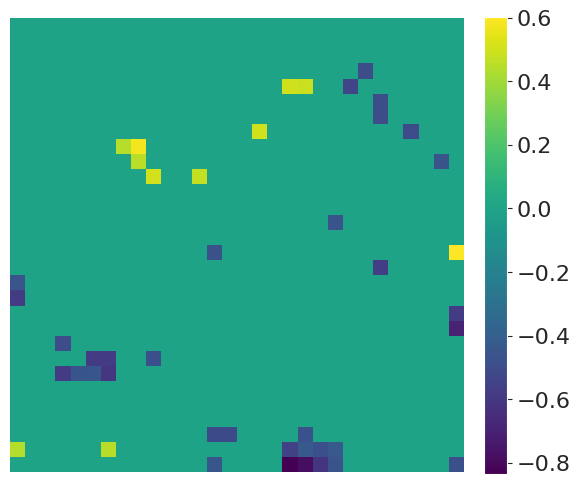

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

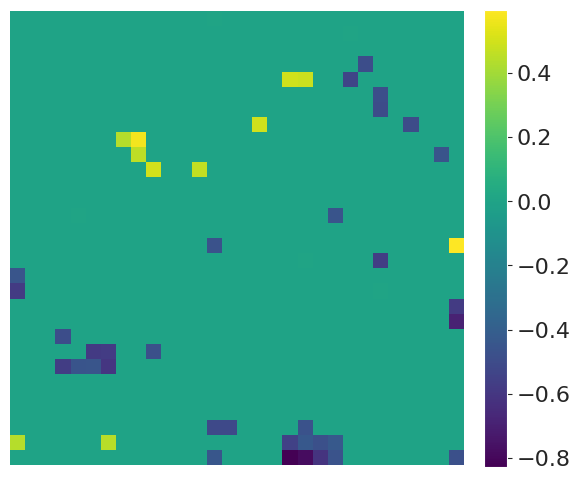

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

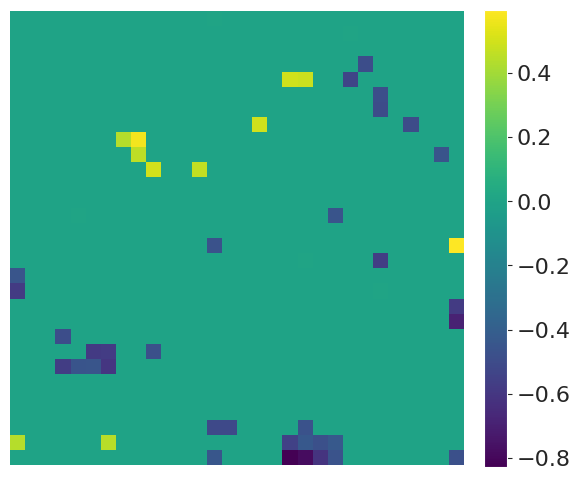

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

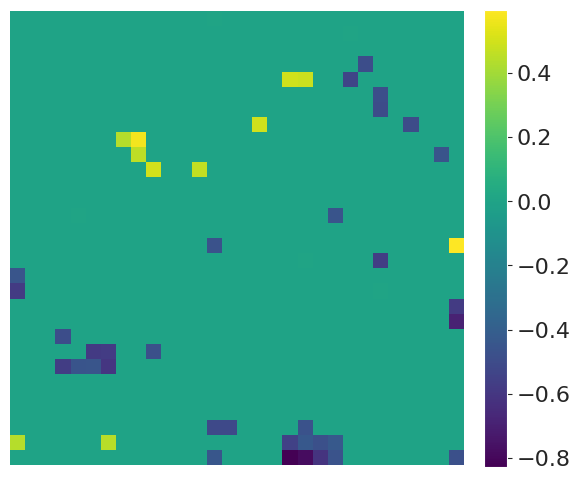

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

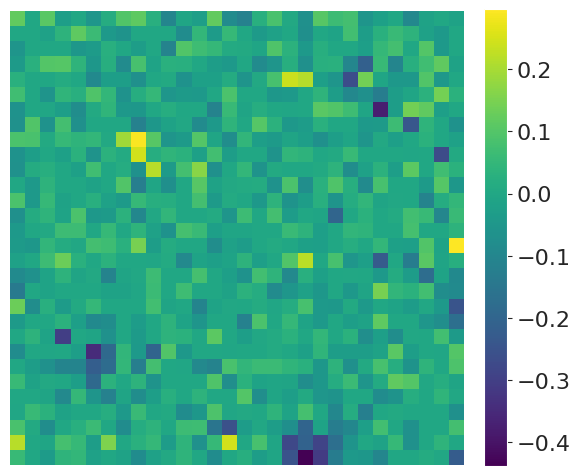

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

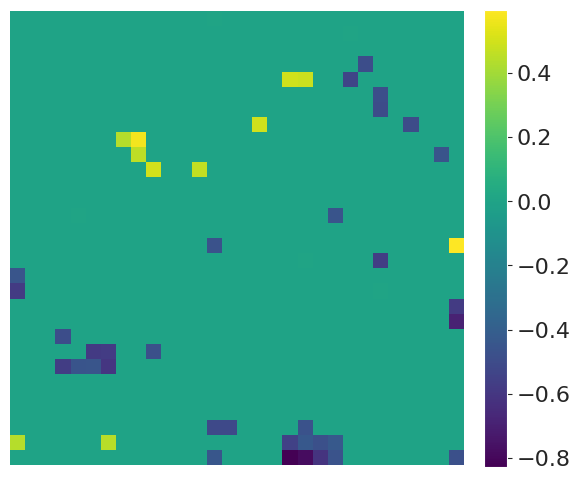

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

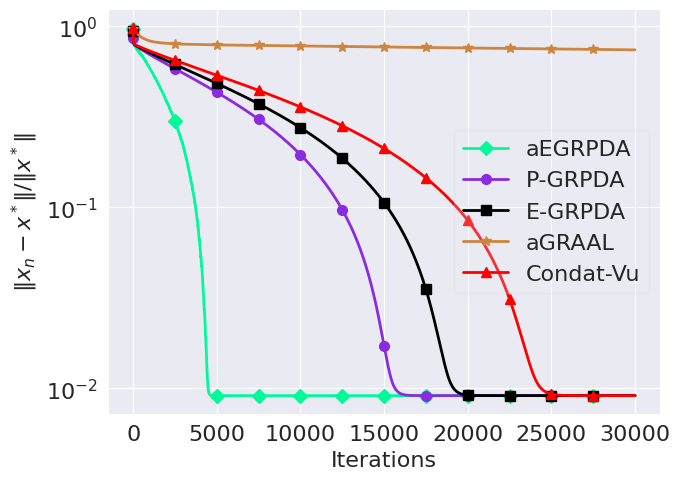

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

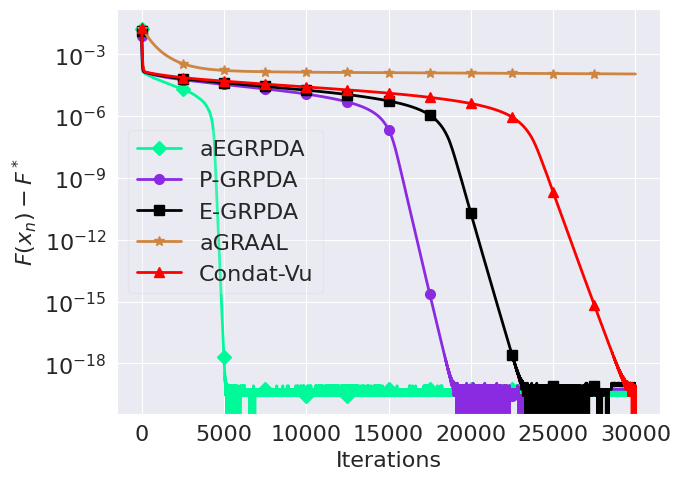

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from google.colab import files  # for download

# ——— 1) Style (unchanged) ———
sns.set_style('darkgrid')
plt.rcParams['legend.facecolor'] = plt.rcParams['axes.facecolor']
plt.rcParams.update({
    'font.size':        13,
    'figure.figsize':   (6, 4),
    'legend.fontsize':  16,
    'lines.linewidth':  2,
    'axes.labelsize':   16,
    'xtick.labelsize':  16,
    'ytick.labelsize':  16,
    'xtick.major.pad':  4,
    'ytick.major.pad':  4,
})

# ——— 2) Unpack results from all four methods ———
_, x1, y1, tt1, sig1, tau1, err1, Fx1 = ans1       # aEGRPDA
_, x2, y2, tt2, sig2, tau2, err2, Fx2 = ans2       # P‑GRPDA
_, x4, y4, tt4, sig4, tau4, err4, Fx4 = ans4       # E‑GRPDA
_, x3, y3, tt3, tau3, err3, Fx3      = ans3       # aGRAAL
_, x5, y5, tt5, sig5, tau5, err5, Fx5 = ans5

# Download each recovery plot
sns.set_style('darkgrid')
plt.rcParams.update({
    'font.size':      13,
    'figure.figsize': (6, 6),
})

nx, ny = data["nx"], data["ny"]

# List
plots = [
    ("True_Vector",      data["x_true"],         "True Vector"),
    ("aEGRPDA_rec",      x1,                     "aEGRPDA Reconstruction"),
    ("P-GRPDA_rec",      x2,                     "P‑GRPDA Reconstruction"),
    ("E-GRPDA_rec",      x4,                     "E‑GRPDA Reconstruction"),
    ("VI-Adaptive_rec",  x3,                     "VI‑Adaptive Reconstruction"),
    ("Condat_Vu_rec",      x4,                     "E‑GRPDA Reconstruction"),
]

for fname, arr, title in plots:
    plt.figure()
    im = plt.imshow(arr.reshape(nx, ny), cmap="viridis")
    # plt.title(title)
    plt.axis('off')
    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.savefig(f"{fname}.eps")
    files.download(f"{fname}.eps")
    plt.show()



# ——— 4) Plot relative error vs iteration
plt.figure(figsize=(7, 5))
markers = ['D', 'o', 's', '*', '^']
for err_hist, label, color, m in zip(
    [err1, err2, err4, err3, err5],
    ["aEGRPDA", "P‑GRPDA", "E‑GRPDA", "aGRAAL", "Condat-Vu"],
    ["#00FA9A", "#8A2BE2", "black", "#CD853F", "red"],
    markers
):
    it = np.arange(len(err_hist))
    me = max(1, len(it)//12)
    plt.semilogy(it, err_hist,
                 color=color,
                 marker=m,
                 markersize=7,
                 markevery=me,
                 label=label)

plt.xlabel("Iterations")
plt.ylabel(r"$\|x_n - x^*\|/\|x^*\|$")
plt.legend(framealpha=0.2, loc='best')
plt.tight_layout()
# plt.savefig('error_vs_iterations.eps', dpi=600)
# files.download('error_vs_iterations.eps')
plt.show()

# ——— 5) Plot gap vs iteration
plt.figure(figsize=(7, 5))
minF = min(min(Fx1), min(Fx2), min(Fx4), min(Fx3), min(Fx5))
for Fx_hist, label, color, m in zip(
    [Fx1, Fx2, Fx4, Fx3, Fx5],
    ["aEGRPDA", "P‑GRPDA", "E‑GRPDA", "aGRAAL", "Condat-Vu"],
    ["#00FA9A", "#8A2BE2", "black", "#CD853F", "red"],
    markers
):
    gap = np.array(Fx_hist) - minF
    it  = np.arange(len(gap))
    me  = max(1, len(it)//12)
    plt.semilogy(it, gap,
                 color=color,
                 marker=m,
                 markersize=7,
                 markevery=me,
                 label=label)

plt.xlabel("Iterations")
plt.ylabel(r"$F(x_n) - F^*$")
plt.legend(framealpha=0.2, loc='best')
plt.tight_layout()
# plt.savefig('gap.eps', dpi=600)
# files.download('gap.eps')
plt.show()
